In [1]:
# Installing pyshark and pandas packages
!pip install pyshark pandas
!pip install nest_asyncio
!apt-get update
!apt-get install -y tshark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 585.7 kB/s eta 0:00:00
Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Ign:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Get:11 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,128 kB]
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:13 http://ar

In [2]:
# importing the packages
import pyshark
import pandas as pd
import nest_asyncio
import asyncio
import matplotlib.pyplot as plt

# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Enabling nested asyncio
nest_asyncio.apply()

# Defining the path to the PCAP file stored in the drive
pcap_file_path = '/content/drive/My Drive/pcap/client.pcap'


Mounted at /content/drive


In [3]:
# Initializing lists to store extracted data
timestamps = []
packet_sizes = []
src_ips = []
dst_ips = []
protocols = []
src_ports = []
dst_ports = []

# Capturing packets and extracting data
cap = pyshark.FileCapture(pcap_file_path)
for packet in cap:
    timestamps.append(packet.sniff_time.timestamp())
    packet_sizes.append(int(packet.length))
    src_ips.append(packet.ip.src)
    dst_ips.append(packet.ip.dst)
    protocols.append(packet.highest_layer)
    if 'TCP' in packet:
        src_ports.append(packet.tcp.srcport)
        dst_ports.append(packet.tcp.dstport)
    elif 'UDP' in packet:
        src_ports.append(packet.udp.srcport)
        dst_ports.append(packet.udp.dstport)
    else:
        src_ports.append(None)
        dst_ports.append(None)
cap.close()

# Creating a dataframe with the extracted data
df = pd.DataFrame({
    'timestamp': timestamps,
    'packet_size': packet_sizes,
    'src_ip': src_ips,
    'dst_ip': dst_ips,
    'protocol': protocols,
    'src_port': src_ports,
    'dst_port': dst_ports
})




In [4]:
# Converting timestamps to integer seconds
df['time_sec'] = df['timestamp'].astype(int)

# Calculating packets per second
packets_per_sec = df.groupby('time_sec').size().reset_index(name='packets_per_sec')

# Merging the packets per second data with the original DataFrame
df = pd.merge(df, packets_per_sec, on='time_sec', how='left')

# Saving the DataFrame to a CSV file in the drive
csv_file_path = '/content/drive/My Drive/pcap/packet_analysis.csv'
df.to_csv(csv_file_path, index=False)

# Displaying the first few rows of the DataFrame
df.head(100)

,timestamp,packet_size,src_ip,dst_ip,protocol,src_port,dst_port,time_sec,packets_per_sec
0,1.719825e+09,74,10.0.0.1,10.0.0.2,TCP,1935,34106,1719825212,24
1,1.719825e+09,66,10.0.0.1,10.0.0.2,TCP,1935,34106,1719825212,24
2,1.719825e+09,66,10.0.0.1,10.0.0.2,TCP,1935,34106,1719825212,24
3,1.719825e+09,1603,10.0.0.1,10.0.0.2,TCP,1935,34106,1719825212,24
4,1.719825e+09,1514,10.0.0.1,10.0.0.2,TCP,1935,34106,1719825212,24
...,...,...,...,...,...,...,...,...,...
95,1.719825e+09,1514,10.0.0.1,10.0.0.2,RTMPT,1935,34106,1719825216,51
96,1.719825e+09,1514,10.0.0.1,10.0.0.2,RTMPT,1935,34106,1719825216,51
97,1.719825e+09,2962,10.0.0.1,10.0.0.2,RTMPT,1935,34106,1719825216,51
98,1.719825e+09,1514,10.0.0.1,10.0.0.2,TCP,1935,34106,1719825216,51


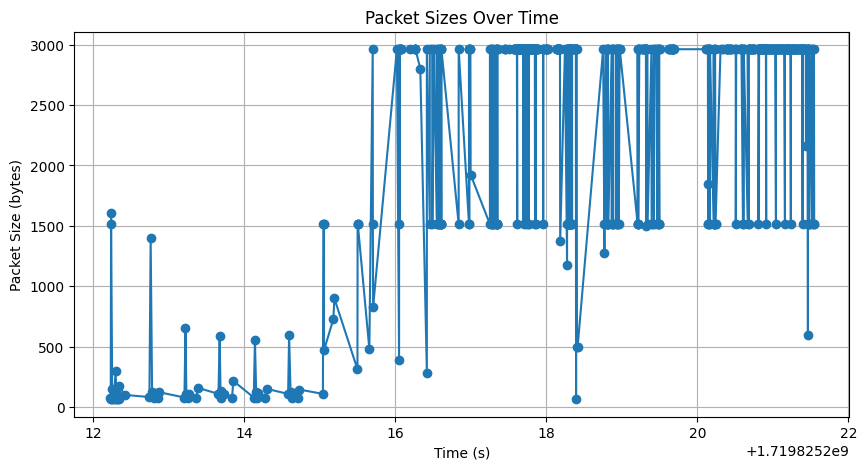

In [5]:
# Plotting packet sizes over time
plt.figure(figsize=(10, 5))
plt.plot(df['timestamp'], df['packet_size'], marker='o')
plt.title('Packet Sizes Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Packet Size (bytes)')
plt.grid(True)
plt.show()

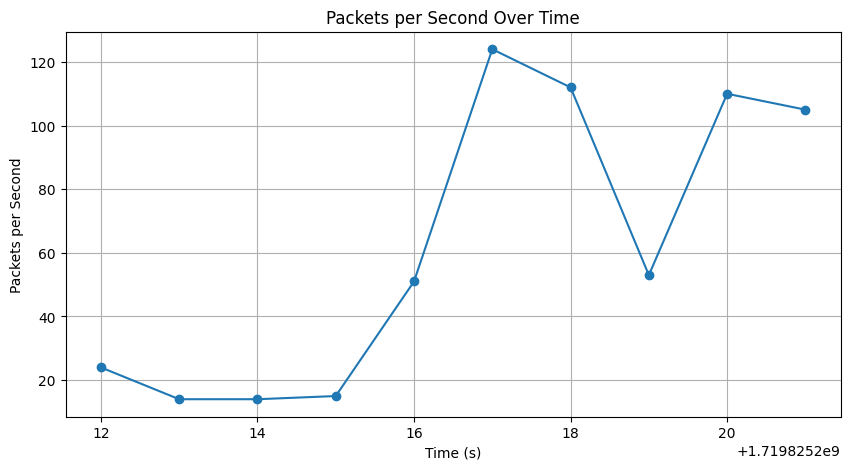

In [6]:
# Plotting transffered packets per second over time
plt.figure(figsize=(10, 5))
plt.plot(packets_per_sec['time_sec'], packets_per_sec['packets_per_sec'], marker='o')
plt.title('Packets per Second Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Packets per Second')
plt.grid(True)
plt.show()

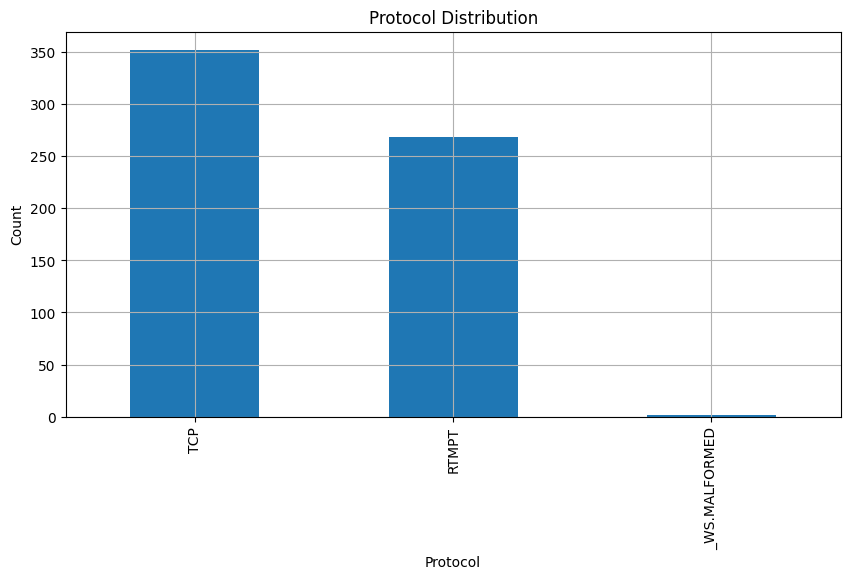

In [7]:
# Analyzing protocol distribution
protocol_counts = df['protocol'].value_counts()
protocol_counts.plot(kind='bar', figsize=(10, 5), title='Protocol Distribution')
plt.xlabel('Protocol')
plt.ylabel('Count')
plt.grid(True)
plt.show()